# Neural network for remotely sensed data
Based on: _Heermann, P. D., & Khazenie, N. (1992). Classification of multispectral remote sensing data using a back-propagation neural network. IEEE Transactions on geoscience and remote sensing, 30(1), 81-88._

In [1]:
# Useful libraries
import numpy as np
import matplotlib.pyplot as plt
import gdal
import tensorflow as tf
from tensorflow import keras

In [2]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


First step is to organize our datasets, first we call in our Training dataset, our testing dataset and the training dataset labels (target labels). Both the training and testing datasets consist of the same area but the images where acquired at different times.

In [3]:
# Function to load raster files as numpy arrays
def load_satrstr(filename):
    dataset = gdal.Open(filename, gdal.GA_ReadOnly)
    # Información de la imagen abierta
    cols = dataset.RasterXSize
    rows = dataset.RasterYSize
    bands = dataset.RasterCount
    # Información de latitud y longitud
    geotransform = dataset.GetGeoTransform()
    xOrigin = geotransform[0]
    yOrigin = geotransform[3]
    pixelWidth = geotransform[1]
    pixelHeight = geotransform[5]
    # Manipulación en forma de arreglo
    raster_array = dataset.ReadAsArray()
    return raster_array

In [4]:
file_test = "Subset_S2B_MSIL2A_20200405T104619_N0214_R051_T31UES_20200405T134034_resampled_clip.tif"
file_train = "Subset_S2B_MSIL2A_20200515T104619_N0214_R051_T31UES_20200515T135604_resampled_clip.tif"
file_lbl = "S2GLC_T31UES_2017_corrected_clip.tif"

# Loading the arrays using the defined function
test_img = load_satrstr(file_test)
train_img = load_satrstr(file_train)
train_lbl = load_satrstr(file_lbl)

# Resulting array dimentions:
print(test_img.shape)
print(train_img.shape)
print(train_lbl.shape)

(10, 2170, 2286)
(10, 2170, 2286)
(2170, 2286)


## Input datasets representation

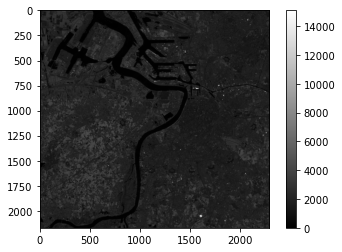

In [5]:
plt.figure()
plt.imshow(train_img[8], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

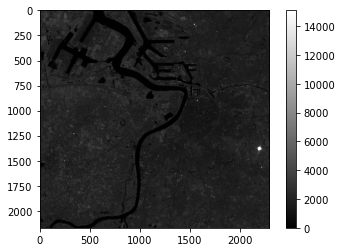

In [6]:
plt.figure()
plt.imshow(test_img[8], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

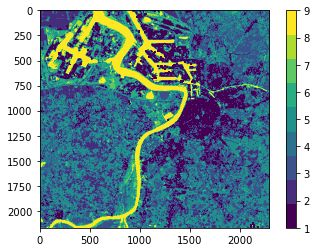

In [7]:
plt.figure()
plt.imshow(train_lbl, vmin=1, vmax=9, cmap=plt.cm.get_cmap('viridis', 9))
plt.colorbar()
plt.grid(False)
plt.show()

## Dataset preparation
Here we correct small errors on the datasets, as well as prepare them on the right format for the neural network input

In [8]:
np.amin(train_lbl) # Abnormal value

-99999.0

We can see that there is an abnormal value in our labels dataset, correcting this is key (because otherwise this value counts as another class), so we clip all values in the matrix not belonging in the labels [1,9]

In [9]:
np.clip(train_lbl, 1, 9, out=train_lbl) 

array([[2., 2., 2., ..., 4., 4., 4.],
       [2., 2., 2., ..., 4., 4., 4.],
       [2., 2., 2., ..., 4., 4., 4.],
       ...,
       [5., 6., 6., ..., 2., 2., 2.],
       [5., 6., 2., ..., 2., 2., 5.],
       [5., 6., 6., ..., 2., 2., 5.]], dtype=float32)

We need to standarize the values in the arrays in values from 0 to 1, we use the computed max value for each dataset to obtain such result.

In [10]:
maxpv_train = np.amax(train_img) # Max pixel value for train ds
maxpv_test = np.amax(test_img) # Max pixel value for test ds

train_img = train_img / maxpv_train
test_img = test_img / maxpv_test

Next, we reshape all the arrays into "flattened bands".

In [11]:
train_img = train_img.reshape(10, 4960620)
test_img = test_img.reshape(10, 4960620)
train_lbl = train_lbl.reshape(4960620)

train_img = train_img.T
test_img = test_img.T
train_lbl = train_lbl.T - 1 # This way it starts at 0 instead of 1

print(train_img.shape)
print(test_img.shape)
print(train_lbl.shape)

(4960620, 10)
(4960620, 10)
(4960620,)


In [12]:
np.unique(train_lbl)

array([0., 1., 2., 3., 4., 5., 6., 7., 8.], dtype=float32)

## Building the neural network

Since there are many ways of building a neural network, two different models are presented, with similar network builds but different activation functions and optimizers.

### Model 1
This is the "simpliest" method, since it uses only sigmoid activation functions except for the output layer, which uses the softmax activation function (because it converts a real vector to a vector of categorical probabilities), and a simple gradient descent optimizer (In Keras, the simpliest gradient descent function is the "Stochastic Gradient Descent", which is just a gradient descent function that automatically adjusts itself. We use the default form of **SGD**, default arguments can be found in https://keras.io/api/optimizers/sgd/).

In [13]:
# Model build
model_1 = keras.Sequential([
    keras.layers.Dense(10, activation='sigmoid'),
    keras.layers.Dense(50, activation='sigmoid'),
    keras.layers.Dense(9, activation='softmax')
])

# Model compile
model_1.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Model 2
In this model, we use the ReLU activation function instead of sigmoid (because it is proven to be easier to optimize). Furthermore, we use the default form of the **Adam** optimizer (https://keras.io/api/optimizers/adam/), which is also a modified version of the gradient descent.

In [14]:
# Model build
model_2 = keras.Sequential([
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(9, activation='softmax')
])

# Model compile
model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Testing the neural network models

### Model 1 testing

In [ ]:
model_1.fit(train_img, train_lbl, epochs=2, batch_size=1024) # Fitting time can be cut down by reducing the epochs

Now we make predictions with our model

In [ ]:
# First, the predictions are made
predictions_1 = model_1.predict(test_img)
# This is necessary since the output of each pixel is a vector of length N where N is the number of classes. The one with the highest value is the one selected to represent the pixel
pred_raster_1 = np.argmax(predictions_1, axis=1)
# Reshaping is necessary to plot the final output
pred_raster_1 = pred_raster_1.reshape(2170, 2286)
# Finally we visualize the result
plt.figure(figsize = (10,10))
plt.imshow(pred_raster_1, vmin=0, vmax=8, cmap=plt.cm.get_cmap('viridis', 9))
plt.colorbar()
plt.grid(False)
plt.title('Classification output for Model 1', fontsize=16)
plt.show()

### Model 2 testing

In [ ]:
model_2.fit(train_img, train_lbl, epochs=2) # Fitting time can be cut down by reducing the epochs

Now we make predictions with our model

In [ ]:
# First, the predictions are made
predictions_2 = model_2.predict(test_img)
# This is necessary since the output of each pixel is a vector of length N where N is the number of classes. The one with the highest value is the one selected to represent the pixel
pred_raster_2 = np.argmax(predictions_2, axis=1)
# Reshaping is necessary to plot the final output
pred_raster_2 = pred_raster_2.reshape(2170, 2286)
# Finally we visualize the result
plt.figure(figsize = (10,10))
plt.imshow(pred_raster_2, vmin=0, vmax=8, cmap=plt.cm.get_cmap('viridis', 9))
plt.colorbar()
plt.grid(False)
plt.title('Classification output for Model 2', fontsize=16)
plt.show()

## Results assessment
Finally, two confusion matrices are built to evaluate the goodness of the classification performed by both models

In [ ]:
# We load sk learn library for cm and seaborn for data presentation
from sklearn.metrics import confusion_matrix
import seaborn as sns

# We reshape the training labels to match the dimesions and data types of the predictions
train_lbl = train_lbl.reshape(4960620).astype('int64')
pred_raster_1 = pred_raster_1.reshape(4960620).astype('int64')
pred_raster_2 = pred_raster_2.reshape(4960620).astype('int64')

# We build the confusion matrices
cm_1 = confusion_matrix(train_lbl, pred_raster_1) # Confusion matrix for model 1 predictions
cm_2 = confusion_matrix(train_lbl, pred_raster_2) # Confusion matrix for model 2 predictions

# We calculate global accuracies
ga_1 = np.trace(cm_1)/4960620 # Global accuracy of model 1
ga_2 = np.trace(cm_2)/4960620

# Now we plot the results

# Model 1 pred
fig1, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,12))
sns.heatmap(cm_1, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
print("Global accuracy of model 1: ", ga_1)
ax.set_xlabel('Predictions');ax.set_ylabel('Real'); 
ax.set_title('Confusion matrix for model 1 predictions'); 
ax.xaxis.set_ticklabels(['Artificial', 'Cultivated', 'Broadleaf', 'Coniferous', 'Herbaceous', 'Moors', 'Marshes', 'Natural Surf.', 'Water']); 
ax.yaxis.set_ticklabels(['Artificial', 'Cultivated', 'Broadleaf', 'Coniferous', 'Herbaceous', 'Moors', 'Marshes', 'Natural Surf.', 'Water']);

# Model 2 pred
print("Global accuracy of model 2: ", ga_2)
fig1, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,12))
sns.heatmap(cm_2, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predictions');ax.set_ylabel('Real'); 
ax.set_title('Confusion matrix for model 2 predictions'); 
ax.xaxis.set_ticklabels(['Artificial', 'Cultivated', 'Broadleaf', 'Coniferous', 'Herbaceous', 'Moors', 'Marshes', 'Natural Surf.', 'Water']); 
ax.yaxis.set_ticklabels(['Artificial', 'Cultivated', 'Broadleaf', 'Coniferous', 'Herbaceous', 'Moors', 'Marshes', 'Natural Surf.', 'Water']);


Now we export the resulting classifications as geoTiffs

In [ ]:
dataset = gdal.Open(file_train, gdal.GA_ReadOnly)

pred_raster_1 =  pred_raster_1.reshape(2170,2286)
dst_filename = 'D:\RESPALDO EDUARDO 2018\Documentos\MML\ProyectoFinal\M1P1_2.tiff'
x_pixels = 2170  # number of pixels in x
y_pixels = 2286  # number of pixels in y
driver = gdal.GetDriverByName('GTiff')
outds = driver.Create(dst_filename,y_pixels, x_pixels, 1,gdal.GDT_Float32)
outds.GetRasterBand(1).WriteArray(pred_raster_1)

# follow code is adding GeoTranform and Projection
geotrans=dataset.GetGeoTransform()  #get GeoTranform from existed 'data0'
proj=dataset.GetProjection() #you can get from a exsited tif or import 
outds.SetGeoTransform(geotrans)
outds.SetProjection(proj)
outds.FlushCache()
outds=None

In [ ]:
pred_raster_2 =  pred_raster_2.reshape(2170,2286)
dst_filename = 'D:\RESPALDO EDUARDO 2018\Documentos\MML\ProyectoFinal\M1P2_2.tiff'
x_pixels = 2170  # number of pixels in x
y_pixels = 2286  # number of pixels in y
driver = gdal.GetDriverByName('GTiff')
outds = driver.Create(dst_filename,y_pixels, x_pixels, 1,gdal.GDT_Float32)
outds.GetRasterBand(1).WriteArray(pred_raster_2)

# follow code is adding GeoTranform and Projection
geotrans=dataset.GetGeoTransform()  #get GeoTranform from existed 'data0'
proj=dataset.GetProjection() #you can get from a exsited tif or import 
outds.SetGeoTransform(geotrans)
outds.SetProjection(proj)
outds.FlushCache()
outds=None

And finally we prepare our data to assess the classification accuracy class-wisely

In [ ]:
T_Artif = np.count_nonzero(train_lbl == 0) # Total "Artificial" pixels on our label dataset
T_Cultv = np.count_nonzero(train_lbl == 1)
T_BroadL = np.count_nonzero(train_lbl == 2)
T_Conif = np.count_nonzero(train_lbl == 3)
T_Herb = np.count_nonzero(train_lbl == 4)
T_Moors = np.count_nonzero(train_lbl == 5)
T_Marshes = np.count_nonzero(train_lbl == 6)
T_NatS = np.count_nonzero(train_lbl == 7)
T_Water = np.count_nonzero(train_lbl == 8)

ac_Artif = cm_1[0][0] / T_Artif # "Artificial" class accuracy
ac_Cultv = cm_1[1][1] / T_Cultv
ac_BroadL = cm_1[2][2] / T_BroadL
ac_Conif = cm_1[3][3] / T_Conif
ac_Herb = cm_1[4][4] / T_Herb
ac_Moors = cm_1[5][5] / T_Moors
ac_Marshes = cm_1[6][6] / T_Marshes
ac_NatS = cm_1[7][7] / T_NatS
ac_Water = cm_1[8][8] / T_Water

class_labels = ['Artificial', 'Cultivated', 'Broadleaf', 'Coniferous', 'Herbaceous', 'Moors', 'Marshes', 'Natural Surf.', 'Water']

In [ ]:
import pandas as pd
accuracies = [ac_Artif, ac_Cultv, ac_BroadL, ac_Conif, ac_Herb, ac_Moors, ac_Marshes, ac_NatS, ac_Water]
df = pd.DataFrame(accuracies, index = class_labels, columns = ['Accuracy']) 
df

In [ ]:
ac_Artif = cm_2[0][0] / T_Artif # "Artificial" class accuracy
ac_Cultv = cm_2[1][1] / T_Cultv
ac_BroadL = cm_2[2][2] / T_BroadL
ac_Conif = cm_2[3][3] / T_Conif
ac_Herb = cm_2[4][4] / T_Herb
ac_Moors = cm_2[5][5] / T_Moors
ac_Marshes = cm_2[6][6] / T_Marshes
ac_NatS = cm_2[7][7] / T_NatS
ac_Water = cm_2[8][8] / T_Water

accuracies = [ac_Artif, ac_Cultv, ac_BroadL, ac_Conif, ac_Herb, ac_Moors, ac_Marshes, ac_NatS, ac_Water]
df = pd.DataFrame(accuracies, index = class_labels, columns = ['Accuracy']) 
df